# Learning rate schedulers comparison

### About experiment


This notebook proposes research on how different learning rate schedulers affect deep learning model performance on image classification task. The dataset in use is Imagenette160 and the model is ResNet34. Research process itself is done via running several repetitions of model training with specific learning rate scheduler from predefined `domain` of options. Model evaluation is done periodically during each of these runs on test part of the dataset. Plots and aggregated metrics at the end of the notebook clearly show the difference between experiments with different learning rate schedulers.

In [1]:
import sys

import numpy as np

sys.path.append('../../..')
from batchflow import Pipeline, B, V, C
from batchflow.opensets import Imagenette160
from batchflow.models.torch import ResNet34
from batchflow.models.metrics import ClassificationMetrics
from batchflow.research import Research, Option, Results, KV, RP
from batchflow.utils import plot_research, print_results

Research parameters:

In [ ]:
NUM_ITERS = 50000                       # number of iterations to train each model for
N_REPS = 7                              # number of times to repeat each model train
RESEARCH_NAME = 'research_schedulers'   # name of Research object
DEVICES = [5, 6, 7]                     # GPUs to use
WORKERS = len(DEVICES)                  # number of simultaneously trained models
TEST_FREQUENCY = 150                    # how often model evaluation on test data is done during train
BATCH_SIZE = 64

dataset = Imagenette160()               # dataset to train models on
N_ITERS_IN_EPOCH = dataset.train.size // BATCH_SIZE

### Research domain

Research domain consists of various learning rate schedulers. They can be compound, meaning you can compose several different schedulers (as a list of dicts).

Scheduler applies decay to learning rate during training on specified iterations. It requires different parameters depending on type.

- `'name'` - name or alias for a chosen learning rate scheduler;
- `'frequency'` — how often scheduler is applied;
- `'first_iter'` — when scheduler starts (default is 0);
- `'last_iter'` — when scheduler stops (default is -1).

Parameter `'name'` must be one of:
- a class name from 
[torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) (e.g. `'LambdaLR'`) __except__ `'ReduceLROnPlateau'`.
- a short name of scheduler from that mapping:

|  Short name |    Scheduler      |
|:------------|:------------------|
|    'exp'    | ExponentialLR     |
| 'lambda'    | LambdaLR          |
| 'step'      | StepLR            |
| 'multistep' | MultiStepLR       |
| 'cos'       | CosineAnnealingLR |

- a class with `_LRScheduler` interface.
- a callable which takes optimizer and optional args.

All other parameters are passed directly to chosen scheduler.

In [ ]:
domain = (Option('decay', [
    KV(None, 'None'),
    KV({'name': 'exp', 'gamma': .96, 'frequency': N_ITERS_IN_EPOCH},
       'exponential_high_frequency'),
    KV({'name': 'exp', 'gamma': .1, 'frequency': N_ITERS_IN_EPOCH * 38},
       'exponential_low_frequency'),
    KV([{'name': 'exp', 'gamma': 1.01, 'frequency': 6, 'last_iter': 900},
        {'name': 'exp', 'gamma': .9994, 'frequency': 2, 'first_iter': 901, 'last_iter': 22000}],
       'warmup_two_stage'),
    KV([{'name': 'exp', 'gamma': .1, 'frequency': 1, 'last_iter': 1},
        {'name': 'exp', 'gamma': 1.0014, 'frequency': 2, 'last_iter': 4500},
        {'name': 'exp', 'gamma': .9995, 'frequency': 5, 'first_iter': 5000}],
       'warmup_three_stage'),
    KV({'name': 'CyclicLR', 'base_lr': .0002, 'max_lr': .0016, 
        'step_size_up': 550, 'cycle_momentum': False, 
        'mode': 'exp_range', 'gamma': .99998, 'frequency': 1},
       'cyclic'),
]))

A short explanation on how each of the defined schedulers work.

- __'None'__ — apply no scheduler;
- __'exponential_high_frequency'__ — apply exponential scheduler on every epoch with given multiplier;
- __'exponential_low_frequency'__ — apply exponential scheduler on each 38th epoch with given multiplier;
- __'warmup_two_stage'__ — firstly increase learning rate every 6th iteration (apply exponential scheduler with given multiplier until 900th iteration), than decrease it every 2nd iteration until the end (with new multiplier, also via exponential scheduler);
- __'warmup_three_stage'__ — decrease learning rate once, then increase it every 2nd iteration until the 4500th. Do nothing till 5000th, then decrease every 5th iteration to the last. All schedulers here are also exponential.
- __'cyclic'__ — apply cyclic scheduler with given params on each iteration from the beginning to the end.

Read more about warmup technique in [this paper](https://arxiv.org/abs/1812.01187v2).

### Model configuration

Config for ResNet34 with 10 classes. Named expression `C` allows substituting variable value at model initialization time. Read more about Batchflow model configuration in [this tutorial](https://github.com/analysiscenter/batchflow/blob/master/examples/tutorials/05_creating_CNN.ipynb).

In [ ]:
config = {
    'inputs/labels/classes': 10,
    'head/layout': 'Vf',
    'decay': C('decay'),
    'device': C('device'),
}

### Train pipeline

Root and branch pipelines for models training. First, `train_root` does data processing common for all branches and then each `train_pipeline` saves loss and learning rate values for further comparison.

In [5]:
train_root = (dataset.train.p      
                  .crop(shape=(160, 160), origin='center')
                  .to_array(channels='first', dtype=np.float32)
                  .multiply(multiplier=1/255)
                  .run_later(BATCH_SIZE, n_epochs=None, drop_last=True,
                             shuffle=True))

train_pipeline = (Pipeline()
                  .init_variable('loss')
                  .init_variable('learning_rate')
                  .init_model('dynamic', ResNet34, 'my_model', config=config) 
                  .train_model('my_model', B('images'), B('labels'), 
                               fetches=['loss', 'lr'], 
                               save_to=[V('loss'), V('learning_rate')]))

### Test pipeline

Test pipeline for model evaluation. It does same data preprocessing as `train_root` and computes confusion matrix on whole test subset for further comparison.

In [6]:
test_pipeline = (dataset.test.p
                 .import_model('my_model', C('import_from'))
                 .init_variable('metrics')
                 .crop(shape=(160, 160), origin='center')
                 .to_array(channels='first', dtype=np.float32)
                 .multiply(multiplier=1/255)
                 .predict_model('my_model', B('images'), fetches='predictions',
                                save_to=B('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=B('predictions'),
                                 fmt='logits', axis=-1, save_to=V('metrics', mode='u'))
                 .run_later(BATCH_SIZE, n_epochs=1, drop_last=False))

### Research

Reseach combines all defined pipelines and runs them in given order and with given frequency. It launches multiple experiments in parallel with options from `domain`.

In [7]:
research = (Research()
            .init_domain(domain, n_reps=N_REPS)
            .add_pipeline(root=train_root, branch=train_pipeline, variables=['loss', 'learning_rate'],
                          name='train_pipeline', logging=True)
            .add_pipeline(test_pipeline, name='test_pipeline', import_from=RP('train_pipeline'), 
                          run=True, logging=True, execute=TEST_FREQUENCY)
            .get_metrics(pipeline='test_pipeline', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', execute=TEST_FREQUENCY))

Start research!

In [ ]:
research.run(NUM_ITERS, name=RESEARCH_NAME,
             devices=DEVICES, workers=WORKERS,
             bar=True)

Research research_schedulers is starting...


Domain updated: 0:  100%|██████████| 2100000/2100000 [101:01:01,  5.47it/s]

### Results and conclusion

Load file with research results.

In [3]:
results = Results(path=RESEARCH_NAME, concat_config=True)

Plots of the learning rate and loss during train and evaluated accuracy on test dataset. Measurements for each model are averaged over `N_REPS` executions.

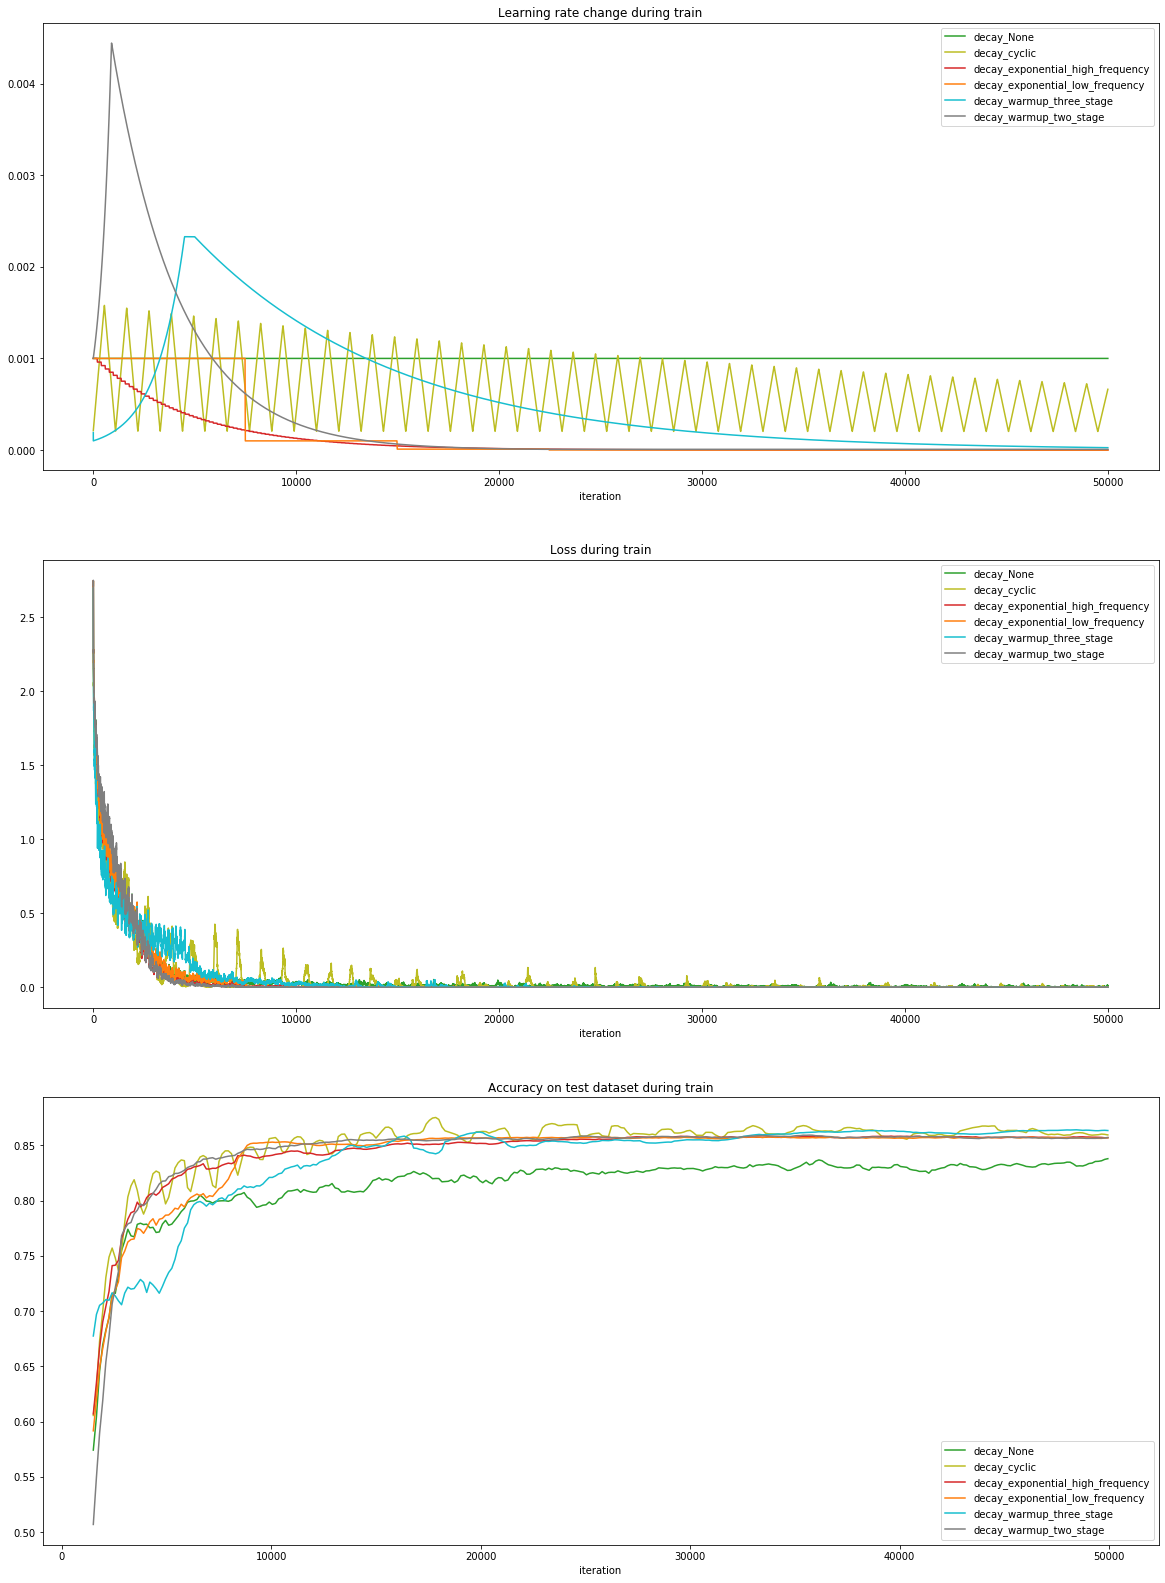

In [6]:
plot_research(results.df, subplots='name', variables=['learning_rate', 'loss', 'accuracy'], aggregate=True,
              title=['Learning rate change during train', 'Loss during train', 'Accuracy on test dataset during train'],
              window=10, nrows=3, ncols=1, figsize=(20, 28))

The table below shows mean and std of evaluated accuracy for each experiment averaged over its repetitions.

In [5]:
print_results(results.df, 'test_pipeline_metrics/accuracy', sort_by='accuracy (mean)', 
              average_repetitions=True, n_last=100)

,accuracy (mean),accuracy (std)
decay_None,0.827045,0.024371
decay_exponential_high_frequency,0.856542,0.008597
decay_cyclic,0.857336,0.010572
decay_exponential_low_frequency,0.858431,0.008556
decay_warmup_two_stage,0.858452,0.010152
decay_warmup_three_stage,0.861936,0.009085


The experiment without any schedulers shows the worst results (mean is the lowest, std is the highest). Therefore we can conclude that for a given dataset usage of learning rate scheduler makes sense.

All tested schedulers achieve relatively equal results. Keep in mind, that they can be tuned more and used on other projects for better performance.